In [8]:
#Choose a Dataset
#Use a pre-annotated dataset for object detection:
#COCO Dataset: Common Objects in Context (80 classes)
#Pascal VOC
#Custom dataset (optional) with annotations in YOLO or COCO format
#from ultralytics import YOLO #How to import a database
#pip install ultralytics


#Install Required Libraries
#pip install opencv-python matplotlib
#pip install tensorflow tensorflow-hub opencv-python matplotlib
#pip install tensorflow scikit-learn opencv-python gTTS




In [93]:
#Import Libraries
import os
import random
import requests
import torch
from PIL import Image
from torch.utils.data import DataLoader
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch.nn.functional as F


from pathlib import Path

In [64]:
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import Trainer


from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)

from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)



In [52]:
#  Simple configuration class for creating the data set
class config:
    
    # Trainer params
    CHECKPOINT_DIR = './.ipynb_checkpoints' # Saves checkpoints

    EXPERIMENT_NAME = 'race_number' # Name of the experiment
    
    # Dataset params
    DATA_DIR = './input' # The data directory
    
    # Training set
    TRAIN_IMAGES_DIR =  './train_images' # Train images folder
    TRAIN_LABELS_DIR = "./train_labels" # Train labels folder

    # Validation
    VAL_IMAGES_DIR = './val_images' # Validation images folder
    VAL_LABELS_DIR = './val_labels' # Validation labels folder (array of points)
    
    # Test set
    TEST_IMAGES_DIR = './test_images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = './test_labels' #child dir of DATA_DIR where test labels are (array of points)

    CLASSES = ['free_parking_space','not_free_parking_space','partially_free_parking_space']
    NUM_CLASSES = len(CLASSES)

    # Dataloader params
    DATALOADER_PARAMS={
    'batch_size': 4,
    'num_workers': 2
    }

    # Model params
    MODEL_NAME = "yolo_nas_l"
    CHECKPOINT_PATH = "model_checkpoints/hub/checkpoints/yolo_nas_l_coco.pth"



# Load your YOLO-NAS model manually with your checkpoint path
model = models.get(
    "yolo_nas_l",
    num_classes=config.NUM_CLASSES,
    checkpoint_path="model_checkpoints/hub/checkpoints/yolo_nas_l_coco.pth",
    load_backbone=True

)
#Test
# Set the model to evaluation mode
model.eval()



YoloNAS_L(
  (backbone): NStageBackbone(
    (stem): YoloNASStem(
      (conv): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        )
        (branch_1x1): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (post_bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (stage1): YoloNASStage(
      (downsample): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=Tr

[2025-04-28 15:19:44] INFO - checkpoint_utils.py - Successfully loaded model's backbone weights from model_checkpoints/hub/checkpoints/yolo_nas_l_coco.pth checkpoint.


In [53]:
# Test model with a dummy input
dummy_input = torch.randn(1, 3, 640, 640)

# Run the dummy input through the model
output = model(dummy_input)

print("Model output:", output)


Model output: ((tensor([[[-59.9788, -59.7512,  67.2141,  67.9515],
         [-51.7062, -59.5525,  75.2167,  67.9200],
         [-43.7929, -59.5264,  83.4645,  68.0240],
         ...,
         [305.0407, 367.0367, 815.9435, 879.7547],
         [337.0310, 367.0389, 847.9437, 879.7515],
         [369.0129, 367.0305, 879.9617, 879.7754]]], grad_fn=<MulBackward0>), tensor([[[0.0103, 0.0099, 0.0106],
         [0.0107, 0.0102, 0.0104],
         [0.0107, 0.0102, 0.0105],
         ...,
         [0.0100, 0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100]]], grad_fn=<SigmoidBackward0>)), (tensor([[[-4.5624, -4.6084, -4.5335],
         [-4.5240, -4.5762, -4.5551],
         [-4.5228, -4.5791, -4.5436],
         ...,
         [-4.5950, -4.5940, -4.5963],
         [-4.5952, -4.5939, -4.5962],
         [-4.5951, -4.5935, -4.5952]]], grad_fn=<PermuteBackward0>), tensor([[[ 0.0575,  0.0288, -0.0224,  ...,  0.0182, -0.0008, -0.0505],
         [ 0.0531,  0.0690, -0.0054,

[2025-04-28 15:19:58] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 16/16 [00:00<00:00, 120.60it/s]
[2025-04-28 15:19:58] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 8/8 [00:00<00:00, 106.57it/s]
[2025-04-28 15:20:00] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 6/6 [00:00<00:00, 119.87it/s]
c:\Users\hanna\anaconda3\envs\tf3\lib\site-packages\super_gradients\training\utils\visualization\utils.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplo

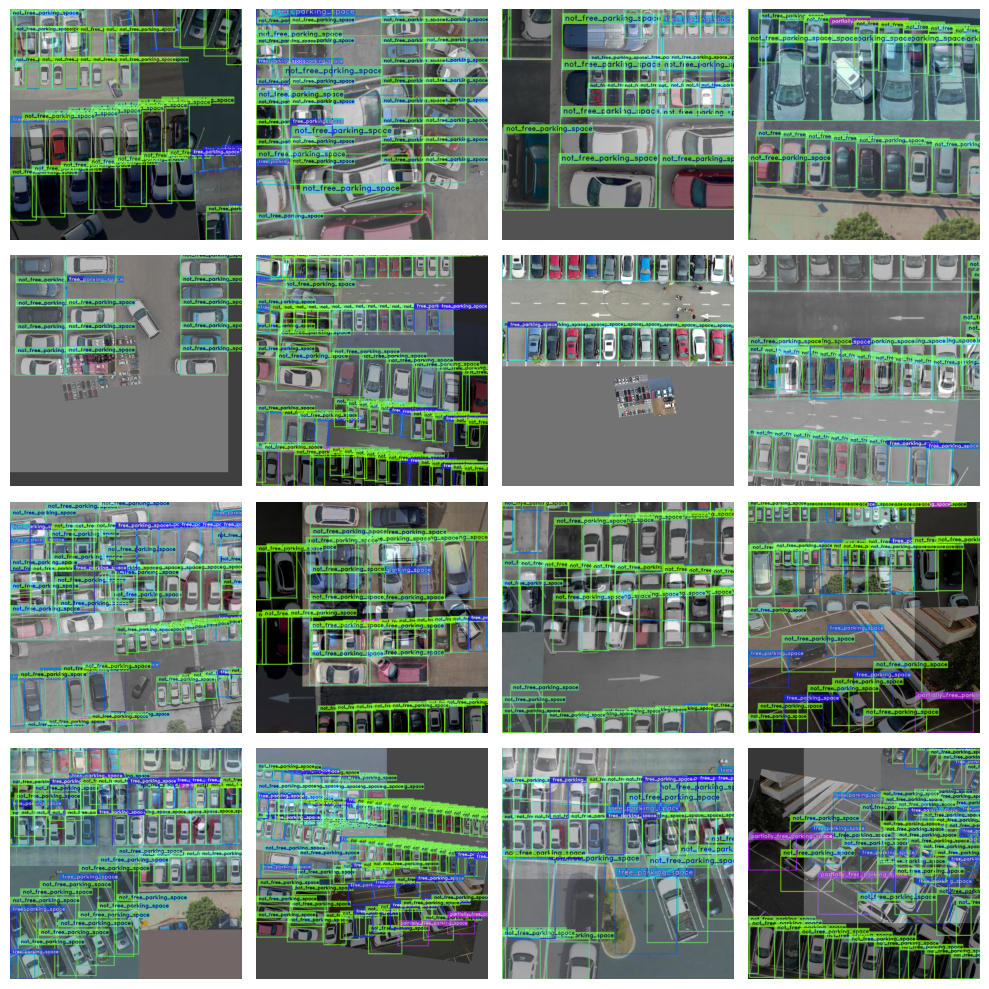

In [54]:
# Creating the dataset
# Split the datat into train, test, and validation sets
# The training dataset
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

# The validation data set
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

# The test data set
test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

train_data.dataset.plot() # Visualize the test images with plotting




In [55]:
# Create the trainer
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

# Define the post prediction callback
post_prediction_callback = PPYoloEPostPredictionCallback(
    score_threshold=0.25,    
    nms_threshold=0.7,      
    nms_top_k=300,          
    max_predictions=100      # maximum predictions per image
)

# Define the training parameters
train_params = {
    "max_epochs": 10,          
    "early_stopping_patience": 5,  # if no val improvement for 5 epochs, stop
    "initial_lr": 5e-4,
    "optimizer": "AdamW",
    "zero_weight_decay_on_bias_and_bn": True,
    "train_loader": train_data,
    "valid_loader": val_data,
    "loss": PPYoloELoss(num_classes=config.NUM_CLASSES, use_static_assigner=False),
    "metric_to_watch": "mAP@0.50",
    "valid_metrics_list": [
        DetectionMetrics_050(
            num_cls=config.NUM_CLASSES,
            post_prediction_callback=post_prediction_callback
        )
    ],
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-5,
    "warmup_epochs": 3,
    "average_best_models": False,  
}

# Start training
trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)


[2025-04-28 15:20:07] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20250428_152007_624898`
[2025-04-28 15:20:07] INFO - sg_trainer.py - Checkpoints directory: ./.ipynb_checkpoints\race_number\RUN_20250428_152007_624898
c:\Users\hanna\anaconda3\envs\tf3\lib\site-packages\super_gradients\common\registry\registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
c:\Users\hanna\anaconda3\envs\tf3\lib\site-packages\super_gradients\training\utils\optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0

The console stream is now moved to ./.ipynb_checkpoints\race_number\RUN_20250428_152007_624898/console_Apr28_15_20_07.txt


c:\Users\hanna\anaconda3\envs\tf3\lib\site-packages\psutil\_pswindows.py:274: DeprecationWarning: getargs: The 'u' format is deprecated. Use 'U' instead.
  total, free = cext.disk_usage(path)
[2025-04-28 15:21:00] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            16         (len(train_set))
    - Batch size per GPU:           4          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             4          (num_gpus * batch_size)
    - Effective Batch size:         4          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         4          (len(train_loader))
    - Gradient updates per epoch:   4          (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_L  (66.91M parameters, 66.91M optimized)
    - Learning Rates and Weight Decays:
      -

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.19
│   ├── Ppyoloeloss/loss_iou = 1.4175
│   ├── Ppyoloeloss/loss_dfl = 1.4464
│   └── Ppyoloeloss/loss = 4.0538
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3268
    ├── Ppyoloeloss/loss_iou = 1.7473
    ├── Ppyoloeloss/loss_dfl = 1.4125
    ├── Ppyoloeloss/loss = 4.4866
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0
    ├── F1@0.50 = 0.0
    └── Best_score_threshold = 0.0



Validating epoch 1: 100%|██████████| 2/2 [00:39<00:00, 19.60s/it]


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0136
│   │   ├── Epoch N-1      = 1.19   (↘ -0.1763)
│   │   └── Best until now = 1.19   (↘ -0.1763)
│   ├── Ppyoloeloss/loss_iou = 1.2484
│   │   ├── Epoch N-1      = 1.4175 (↘ -0.1691)
│   │   └── Best until now = 1.4175 (↘ -0.1691)
│   ├── Ppyoloeloss/loss_dfl = 1.376
│   │   ├── Epoch N-1      = 1.4464 (↘ -0.0704)
│   │   └── Best until now = 1.4464 (↘ -0.0704)
│   └── Ppyoloeloss/loss = 3.638
│       ├── Epoch N-1      = 4.0538 (↘ -0.4158)
│       └── Best until now = 4.0538 (↘ -0.4158)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2907
    │   ├── Epoch N-1      = 1.3268 (↘ -0.0361)
    │   └── Best until now = 1.3268 (↘ -0.0361)
    ├── Ppyoloeloss/loss_iou = 1.7839
    │   ├── Epoch N-1      = 1.7473 (↗ 0.0367)
    │   └── Best until now = 1.7473 (↗ 0.0367)
    ├── Ppyoloeloss/loss_dfl = 1.4207
    │   ├── Epoch N-1      = 1.4125 (↗ 0.0082)
    │   └── Best until now = 1.4125 (↗ 0.0082)
    ├── Ppyoloeloss/loss = 4

Validating epoch 2: 100%|██████████| 2/2 [00:33<00:00, 16.74s/it]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0658
│   │   ├── Epoch N-1      = 1.0136 (↗ 0.0522)
│   │   └── Best until now = 1.0136 (↗ 0.0522)
│   ├── Ppyoloeloss/loss_iou = 1.1433
│   │   ├── Epoch N-1      = 1.2484 (↘ -0.1051)
│   │   └── Best until now = 1.2484 (↘ -0.1051)
│   ├── Ppyoloeloss/loss_dfl = 1.3264
│   │   ├── Epoch N-1      = 1.376  (↘ -0.0496)
│   │   └── Best until now = 1.376  (↘ -0.0496)
│   └── Ppyoloeloss/loss = 3.5355
│       ├── Epoch N-1      = 3.638  (↘ -0.1026)
│       └── Best until now = 3.638  (↘ -0.1026)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.339
    │   ├── Epoch N-1      = 1.2907 (↗ 0.0483)
    │   └── Best until now = 1.2907 (↗ 0.0483)
    ├── Ppyoloeloss/loss_iou = 1.7638
    │   ├── Epoch N-1      = 1.7839 (↘ -0.0201)
    │   └── Best until now = 1.7473 (↗ 0.0166)
    ├── Ppyoloeloss/loss_dfl = 1.4253
    │   ├── Epoch N-1      = 1.4207 (↗ 0.0046)
    │   └── Best until now = 1.4125 (↗ 0.0127)
    ├── Ppyoloeloss/loss = 4.5

Validating epoch 3: 100%|██████████| 2/2 [00:32<00:00, 16.24s/it]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9043
│   │   ├── Epoch N-1      = 1.0658 (↘ -0.1615)
│   │   └── Best until now = 1.0136 (↘ -0.1093)
│   ├── Ppyoloeloss/loss_iou = 1.25
│   │   ├── Epoch N-1      = 1.1433 (↗ 0.1067)
│   │   └── Best until now = 1.1433 (↗ 0.1067)
│   ├── Ppyoloeloss/loss_dfl = 1.2426
│   │   ├── Epoch N-1      = 1.3264 (↘ -0.0838)
│   │   └── Best until now = 1.3264 (↘ -0.0838)
│   └── Ppyoloeloss/loss = 3.3968
│       ├── Epoch N-1      = 3.5355 (↘ -0.1386)
│       └── Best until now = 3.5355 (↘ -0.1386)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.256
    │   ├── Epoch N-1      = 1.339  (↘ -0.083)
    │   └── Best until now = 1.2907 (↘ -0.0347)
    ├── Ppyoloeloss/loss_iou = 1.8371
    │   ├── Epoch N-1      = 1.7638 (↗ 0.0733)
    │   └── Best until now = 1.7473 (↗ 0.0898)
    ├── Ppyoloeloss/loss_dfl = 1.4345
    │   ├── Epoch N-1      = 1.4253 (↗ 0.0092)
    │   └── Best until now = 1.4125 (↗ 0.0219)
    ├── Ppyoloeloss/loss = 4.527

Validating epoch 4: 100%|██████████| 2/2 [00:32<00:00, 16.12s/it]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9657
│   │   ├── Epoch N-1      = 0.9043 (↗ 0.0614)
│   │   └── Best until now = 0.9043 (↗ 0.0614)
│   ├── Ppyoloeloss/loss_iou = 1.1378
│   │   ├── Epoch N-1      = 1.25   (↘ -0.1121)
│   │   └── Best until now = 1.1433 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_dfl = 1.2094
│   │   ├── Epoch N-1      = 1.2426 (↘ -0.0332)
│   │   └── Best until now = 1.2426 (↘ -0.0332)
│   └── Ppyoloeloss/loss = 3.3129
│       ├── Epoch N-1      = 3.3968 (↘ -0.084)
│       └── Best until now = 3.3968 (↘ -0.084)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3294
    │   ├── Epoch N-1      = 1.256  (↗ 0.0733)
    │   └── Best until now = 1.256  (↗ 0.0733)
    ├── Ppyoloeloss/loss_iou = 1.7993
    │   ├── Epoch N-1      = 1.8371 (↘ -0.0378)
    │   └── Best until now = 1.7473 (↗ 0.0521)
    ├── Ppyoloeloss/loss_dfl = 1.437
    │   ├── Epoch N-1      = 1.4345 (↗ 0.0025)
    │   └── Best until now = 1.4125 (↗ 0.0245)
    ├── Ppyoloeloss/loss = 4.565

Validating epoch 5: 100%|██████████| 2/2 [00:33<00:00, 16.65s/it]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9286
│   │   ├── Epoch N-1      = 0.9657 (↘ -0.037)
│   │   └── Best until now = 0.9043 (↗ 0.0243)
│   ├── Ppyoloeloss/loss_iou = 1.1364
│   │   ├── Epoch N-1      = 1.1378 (↘ -0.0014)
│   │   └── Best until now = 1.1378 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_dfl = 1.1833
│   │   ├── Epoch N-1      = 1.2094 (↘ -0.026)
│   │   └── Best until now = 1.2094 (↘ -0.026)
│   └── Ppyoloeloss/loss = 3.2484
│       ├── Epoch N-1      = 3.3129 (↘ -0.0645)
│       └── Best until now = 3.3129 (↘ -0.0645)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2338
    │   ├── Epoch N-1      = 1.3294 (↘ -0.0955)
    │   └── Best until now = 1.256  (↘ -0.0222)
    ├── Ppyoloeloss/loss_iou = 1.7397
    │   ├── Epoch N-1      = 1.7993 (↘ -0.0596)
    │   └── Best until now = 1.7473 (↘ -0.0075)
    ├── Ppyoloeloss/loss_dfl = 1.4199
    │   ├── Epoch N-1      = 1.437  (↘ -0.0171)
    │   └── Best until now = 1.4125 (↗ 0.0074)
    ├── Ppyoloeloss/loss = 

Validating epoch 6: 100%|██████████| 2/2 [00:34<00:00, 17.43s/it]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8925
│   │   ├── Epoch N-1      = 0.9286 (↘ -0.0362)
│   │   └── Best until now = 0.9043 (↘ -0.0118)
│   ├── Ppyoloeloss/loss_iou = 1.0514
│   │   ├── Epoch N-1      = 1.1364 (↘ -0.085)
│   │   └── Best until now = 1.1364 (↘ -0.085)
│   ├── Ppyoloeloss/loss_dfl = 1.0947
│   │   ├── Epoch N-1      = 1.1833 (↘ -0.0886)
│   │   └── Best until now = 1.1833 (↘ -0.0886)
│   └── Ppyoloeloss/loss = 3.0386
│       ├── Epoch N-1      = 3.2484 (↘ -0.2097)
│       └── Best until now = 3.2484 (↘ -0.2097)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2137
    │   ├── Epoch N-1      = 1.2338 (↘ -0.0201)
    │   └── Best until now = 1.2338 (↘ -0.0201)
    ├── Ppyoloeloss/loss_iou = 1.3965
    │   ├── Epoch N-1      = 1.7397 (↘ -0.3432)
    │   └── Best until now = 1.7397 (↘ -0.3432)
    ├── Ppyoloeloss/loss_dfl = 1.1947
    │   ├── Epoch N-1      = 1.4199 (↘ -0.2252)
    │   └── Best until now = 1.4125 (↘ -0.2178)
    ├── Ppyoloeloss/loss

Validating epoch 7: 100%|██████████| 2/2 [00:29<00:00, 14.93s/it]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9371
│   │   ├── Epoch N-1      = 0.8925 (↗ 0.0446)
│   │   └── Best until now = 0.8925 (↗ 0.0446)
│   ├── Ppyoloeloss/loss_iou = 1.1069
│   │   ├── Epoch N-1      = 1.0514 (↗ 0.0555)
│   │   └── Best until now = 1.0514 (↗ 0.0555)
│   ├── Ppyoloeloss/loss_dfl = 1.1331
│   │   ├── Epoch N-1      = 1.0947 (↗ 0.0384)
│   │   └── Best until now = 1.0947 (↗ 0.0384)
│   └── Ppyoloeloss/loss = 3.1771
│       ├── Epoch N-1      = 3.0386 (↗ 0.1385)
│       └── Best until now = 3.0386 (↗ 0.1385)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1429
    │   ├── Epoch N-1      = 1.2137 (↘ -0.0708)
    │   └── Best until now = 1.2137 (↘ -0.0708)
    ├── Ppyoloeloss/loss_iou = 1.4464
    │   ├── Epoch N-1      = 1.3965 (↗ 0.0499)
    │   └── Best until now = 1.3965 (↗ 0.0499)
    ├── Ppyoloeloss/loss_dfl = 1.2333
    │   ├── Epoch N-1      = 1.1947 (↗ 0.0386)
    │   └── Best until now = 1.1947 (↗ 0.0386)
    ├── Ppyoloeloss/loss = 3.8226


Validating epoch 8: 100%|██████████| 2/2 [00:27<00:00, 13.87s/it]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8668
│   │   ├── Epoch N-1      = 0.9371 (↘ -0.0703)
│   │   └── Best until now = 0.8925 (↘ -0.0257)
│   ├── Ppyoloeloss/loss_iou = 1.0237
│   │   ├── Epoch N-1      = 1.1069 (↘ -0.0832)
│   │   └── Best until now = 1.0514 (↘ -0.0277)
│   ├── Ppyoloeloss/loss_dfl = 1.0211
│   │   ├── Epoch N-1      = 1.1331 (↘ -0.1121)
│   │   └── Best until now = 1.0947 (↘ -0.0737)
│   └── Ppyoloeloss/loss = 2.9116
│       ├── Epoch N-1      = 3.1771 (↘ -0.2655)
│       └── Best until now = 3.0386 (↘ -0.1271)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9296
    │   ├── Epoch N-1      = 1.1429 (↘ -0.2133)
    │   └── Best until now = 1.1429 (↘ -0.2133)
    ├── Ppyoloeloss/loss_iou = 1.7006
    │   ├── Epoch N-1      = 1.4464 (↗ 0.2542)
    │   └── Best until now = 1.3965 (↗ 0.3041)
    ├── Ppyoloeloss/loss_dfl = 1.3313
    │   ├── Epoch N-1      = 1.2333 (↗ 0.0981)
    │   └── Best until now = 1.1947 (↗ 0.1366)
    ├── Ppyoloeloss/loss =

Validating epoch 9: 100%|██████████| 2/2 [00:30<00:00, 15.25s/it]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9541
│   │   ├── Epoch N-1      = 0.8668 (↗ 0.0873)
│   │   └── Best until now = 0.8668 (↗ 0.0873)
│   ├── Ppyoloeloss/loss_iou = 0.9569
│   │   ├── Epoch N-1      = 1.0237 (↘ -0.0668)
│   │   └── Best until now = 1.0237 (↘ -0.0668)
│   ├── Ppyoloeloss/loss_dfl = 1.06
│   │   ├── Epoch N-1      = 1.0211 (↗ 0.0389)
│   │   └── Best until now = 1.0211 (↗ 0.0389)
│   └── Ppyoloeloss/loss = 2.971
│       ├── Epoch N-1      = 2.9116 (↗ 0.0594)
│       └── Best until now = 2.9116 (↗ 0.0594)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2881
    │   ├── Epoch N-1      = 0.9296 (↗ 0.3585)
    │   └── Best until now = 0.9296 (↗ 0.3585)
    ├── Ppyoloeloss/loss_iou = 1.797
    │   ├── Epoch N-1      = 1.7006 (↗ 0.0964)
    │   └── Best until now = 1.3965 (↗ 0.4005)
    ├── Ppyoloeloss/loss_dfl = 1.4393
    │   ├── Epoch N-1      = 1.3313 (↗ 0.108)
    │   └── Best until now = 1.1947 (↗ 0.2446)
    ├── Ppyoloeloss/loss = 4.5244
    │

[2025-04-28 15:42:59] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [60]:
# Find the latest run folder inside .ipynb_checkpoints/race_number/
runs = glob.glob('./.ipynb_checkpoints/race_number/RUN_*')
latest_run = max(runs, key=os.path.getmtime)  # Pick the most recent one

# Path to ckpt_best.pth inside that run
checkpoint_path = os.path.join(latest_run, 'ckpt_best.pth')

# Now load the model
model = models.get(
    "yolo_nas_l",
    num_classes=config.NUM_CLASSES,
    checkpoint_path=checkpoint_path
)

model.eval()

YoloNAS_L(
  (backbone): NStageBackbone(
    (stem): YoloNASStem(
      (conv): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        )
        (branch_1x1): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (post_bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (stage1): YoloNASStage(
      (downsample): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=Tr

[2025-04-28 15:50:12] INFO - checkpoint_utils.py - Successfully loaded model weights from ./.ipynb_checkpoints/race_number\RUN_20250428_152007_624898\ckpt_best.pth checkpoint.


Max score in this prediction: 0.10266803950071335


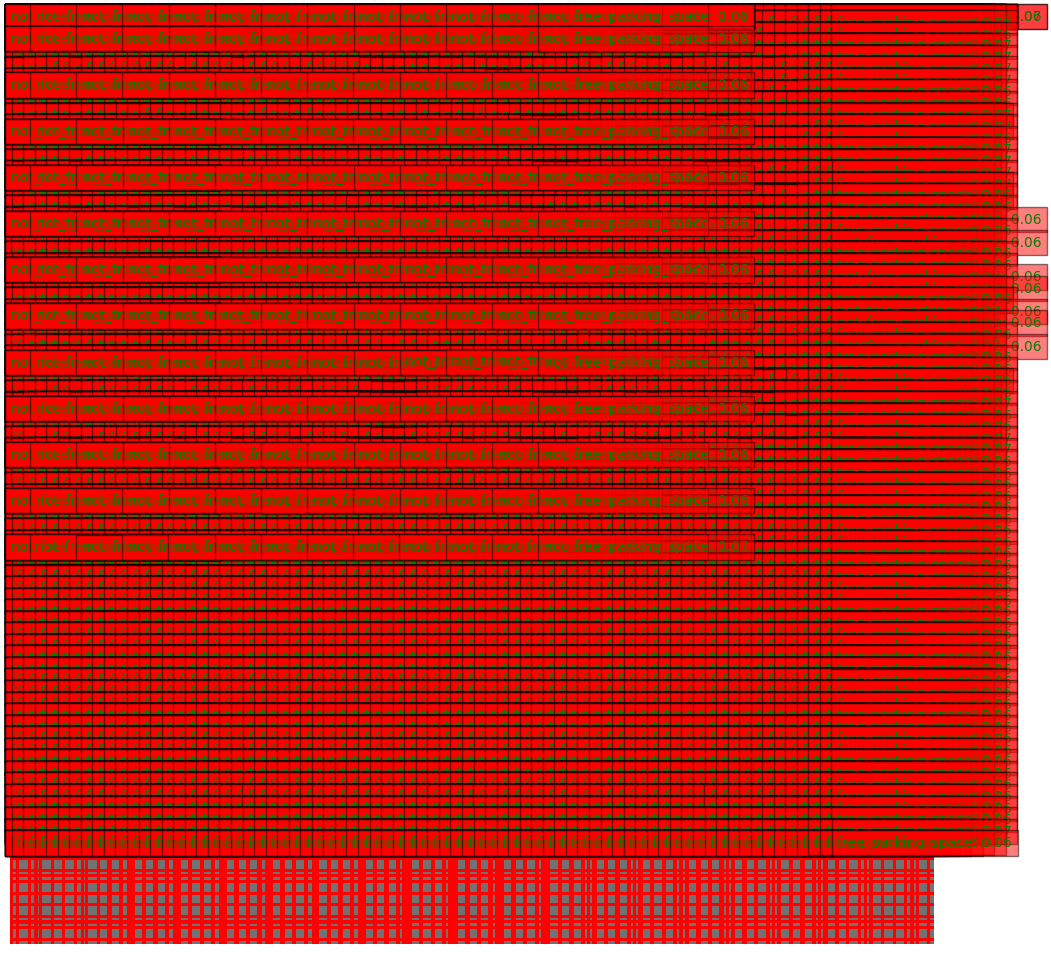

Max score in this prediction: 0.09779242426156998


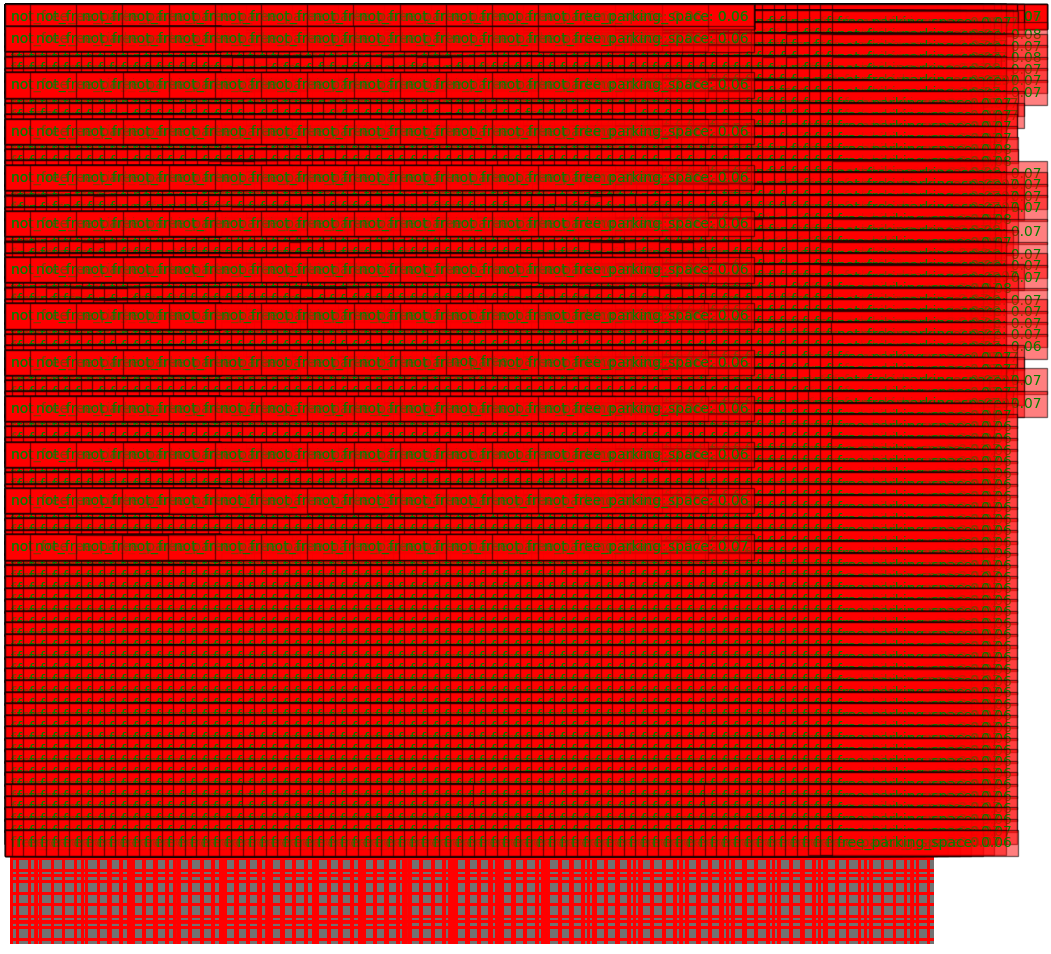

Max score in this prediction: 0.1027168408036232


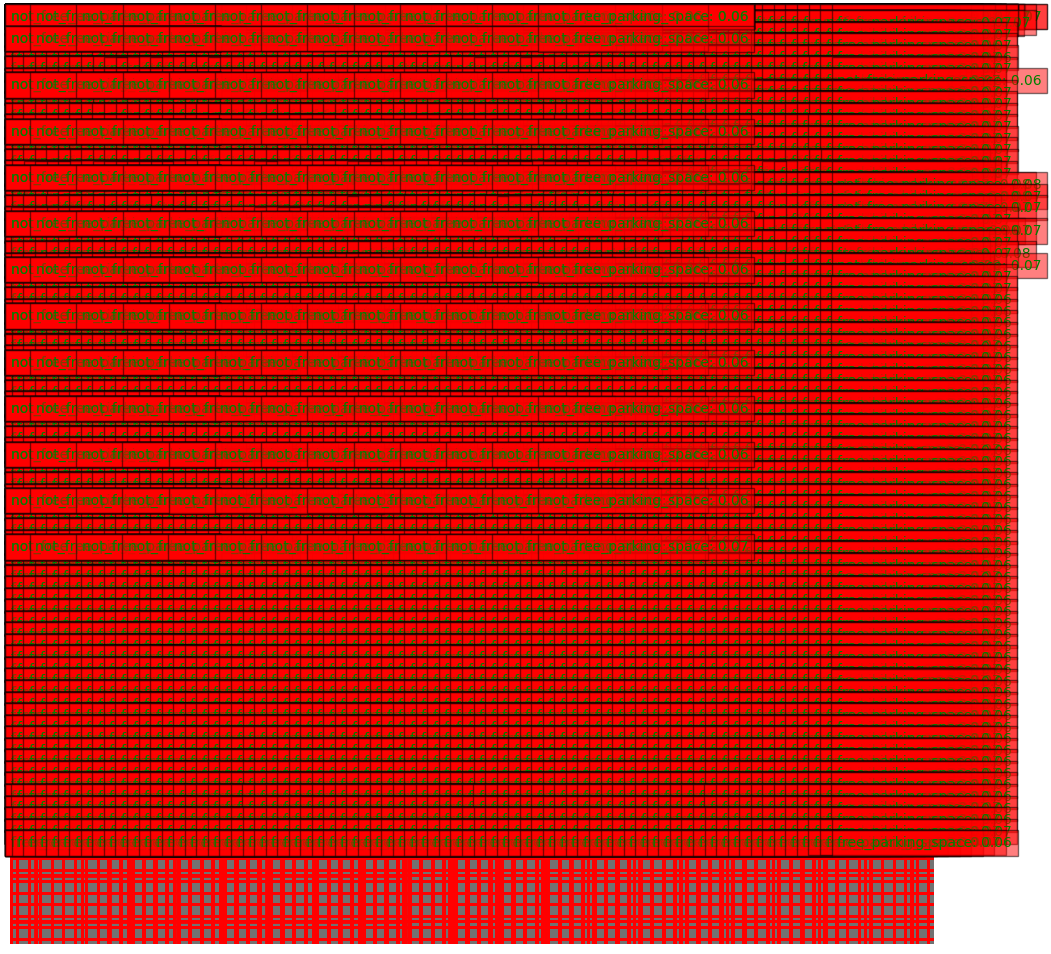

Max score in this prediction: 0.09855000674724579


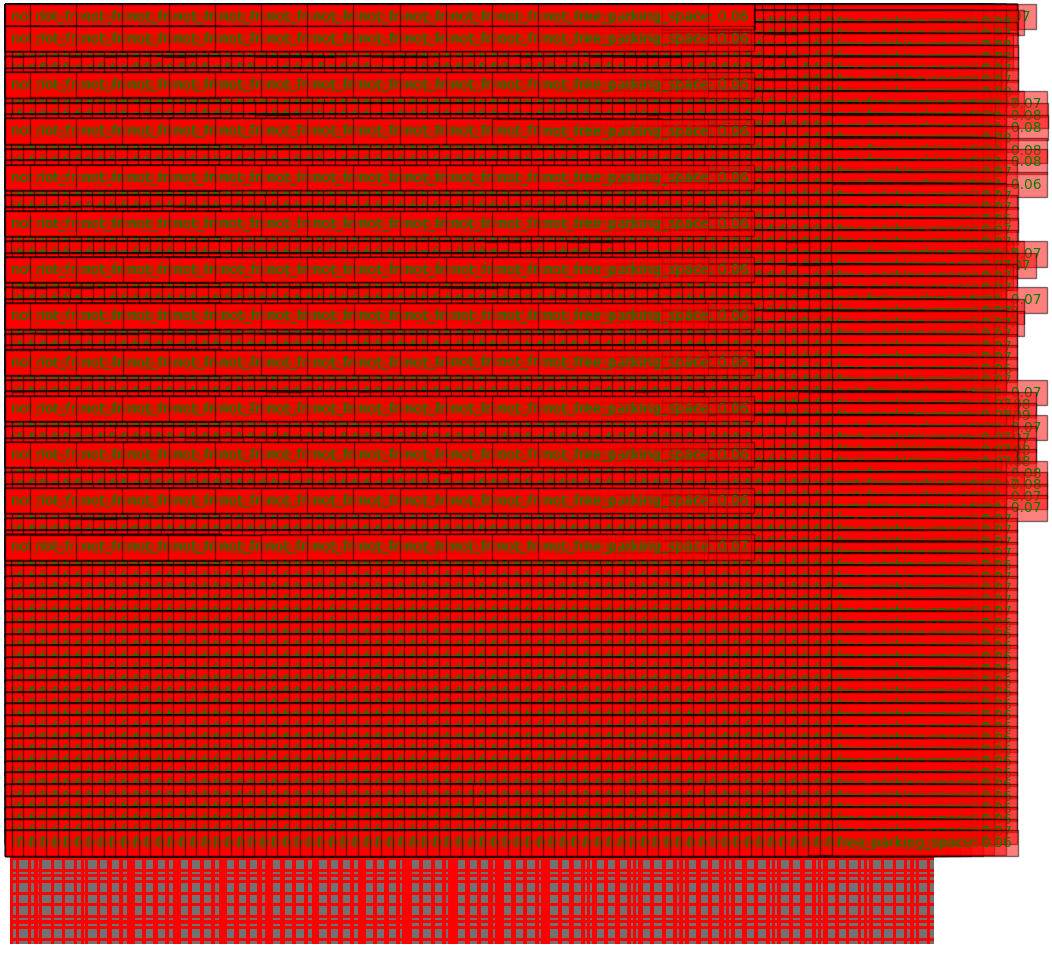

In [103]:
# Get a batch
val_images, val_labels = next(iter(val_data))

# Predict
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

with torch.no_grad():
    outputs = model(val_images.to(device))

# Extract the prediction tensors:
# outputs[0] is a tuple; its first element holds the bounding boxes tensor.
boxes_tensor = outputs[0][0]
# outputs[1] is a tuple; its second element holds the classification scores tensor.
class_scores_tensor = outputs[1][1]

def draw_predictions(image, predictions, class_names, conf_threshold=0.05):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import numpy as np
    import torch.nn.functional as F
    
    # Convert image to numpy if it's a tensor.
    if isinstance(image, torch.Tensor):
        # If the image was normalized, de-normalize if necessary.
        image_np = image.permute(1, 2, 0).cpu().numpy()
    else:
        image_np = image

    # Get image dimensions for clipping.
    H, W, _ = image_np.shape

    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image_np.astype(np.uint8))

    # Unpack predictions: expecting (bounding boxes, class_scores)
    bboxes, class_scores = predictions

    # Remove extra batch dimension if present.
    if bboxes.dim() == 3:
        bboxes = bboxes[0]
    if class_scores.dim() == 3:
        class_scores = class_scores[0]

    # Convert to numpy arrays.
    # bboxes shape: (num_boxes, 4); class_scores shape: (num_boxes, num_channels)
    bboxes = bboxes.cpu().numpy()
    class_scores = class_scores.cpu().numpy()

    # --- FIX START: Ensure that the number of class score channels matches the number of classes ---
    num_classes = len(class_names)
    if class_scores.shape[1] > num_classes:
        class_scores = class_scores[:, :num_classes]
    # --- FIX END ---

    # Determine the best class and its score per detection.
    labels = class_scores.argmax(axis=1)  # Best class index per box.
    scores = class_scores.max(axis=1)       # Best class confidence per box.

    # Debug print of maximum score.
    print(f"Max score in this prediction: {scores.max()}")

    # Loop over each detection.
    for bbox, score, label in zip(bboxes, scores, labels):
        if score < conf_threshold:
            continue

        # Extract bounding box coordinates.
        x1, y1, x2, y2 = bbox
        # Clip coordinates to lie within the image.
        x1, y1 = np.clip([x1, y1], 0, [W, H])
        x2, y2 = np.clip([x2, y2], 0, [W, H])
        
        # Draw bounding box.
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # Draw label and score.
        ax.text(x1, y1, f'{class_names[label]}: {score:.2f}', color='green',
                bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Determine the batch size from the bounding boxes tensor.
batch_size = boxes_tensor.shape[0]

# Visualize each image in the batch.
for idx in range(batch_size):
    img = val_images[idx]
    # Extract per-image predictions along the batch dimension.
    bbox_pred = boxes_tensor[idx]
    class_scores_pred = class_scores_tensor[idx]
    
    # Build the prediction tuple for the current image.
    pred = (bbox_pred, class_scores_pred)
    draw_predictions(img, pred, class_names=config.CLASSES, conf_threshold=0.05)


In [87]:
print(f"Outputs[0]: {outputs[0]}")
print(f"Outputs[1]: {outputs[1]}")



print(f"Outputs type: {type(outputs)}")
print(f"Outputs shape: {len(outputs)}")  # If it's a list/tuple



Outputs[0]: (tensor([[[-59.5833, -59.8365,  67.4337,  68.0240],
         [-51.6000, -59.7860,  75.4988,  68.0580],
         [-43.6529, -59.8514,  83.4735,  68.0301],
         ...,
         [305.1521, 367.2757, 815.8482, 879.9077],
         [337.1343, 367.2906, 847.8674, 879.8730],
         [369.1566, 367.2827, 879.8035, 879.9197]],

        [[-59.4537, -59.5616,  66.9579,  67.9457],
         [-51.5069, -59.7333,  75.1234,  67.8700],
         [-43.5424, -59.7866,  83.3987,  67.9963],
         ...,
         [305.1424, 367.2773, 815.8367, 879.8998],
         [337.1359, 367.2815, 847.8646, 879.8696],
         [369.1462, 367.2752, 879.8040, 879.9120]],

        [[-59.5756, -59.7503,  67.3677,  67.9596],
         [-51.6170, -59.7989,  75.3935,  67.9863],
         [-43.6117, -59.8386,  83.5126,  68.0113],
         ...,
         [305.1338, 367.2817, 815.8362, 879.8957],
         [337.1332, 367.2810, 847.8577, 879.8600],
         [369.1431, 367.2760, 879.8030, 879.9050]],

        [[-59.4643, -

In [94]:
for idx in range(batch_size):
    bbox_pred = boxes_tensor[idx]
    class_scores_pred = class_scores_tensor[idx]
    # Compute probabilities if needed (or leave as is if already probabilities)
    score_values = class_scores_pred.cpu().numpy().max(axis=1)
    print(f"Image {idx} max score: {score_values.max()}")


Image 0 max score: 0.12870609760284424
Image 1 max score: 0.13279588520526886
Image 2 max score: 0.1351088136434555
Image 3 max score: 0.12825165688991547


In [49]:
import os

checkpoint_path = os.path.abspath("../ipynb_checkpoints/race_number/checkpoints/ckpt_best.pth")
print(checkpoint_path)


c:\Users\hanna\AI\ipynb_checkpoints\race_number\checkpoints\ckpt_best.pth


NameError: name 'bboxes' is not defined